This notebook uses [PyTorch](https://pytorch.org/), which is a library that can automatically differentiate functions and is commonly used to implement neural networks. Because of its capability to automatically differentiate functions, the formula for the gradient does not need to be manually derived -- this comes especially handy when working with neural networks, whose gradient formula can be quite complicated, especially for complex architectures. 

We recommend going over the [PyTorch tutorial](https://pytorch.org/tutorials/beginner/basics/intro.html) and then the starter code below. For any new functions that you come across, you can look up the documentation [here](https://pytorch.org/docs/stable/index.html). 

We recommend running this notebook on Google Colab to avoid having to install PyTorch and to take advantage of GPUs, which make training faster.

## Load packages

In [1]:
# load packages
# make sure to install the pacakge "tqdm" for the progress bar when training.
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import imageio
import matplotlib.image as mpimg
from scipy import ndimage

path_prefix = ""
print("Finish!")

Finish!


If running on Google Colab, you need to upload the file `autoencoder_starter.py`. To do so, you need to click on the folder icon on the left side of the page, which brings up a panel that would allow you to upload files. Note however uploading the file this way has a downside in that if your Python runtime times out or is otherwise restarted, the file will be erased and you will need to re-upload. 

If you would like to avoid this, you can create a directory named `CMPT_726Fall2021_A3` in your Google Drive and upload `autoencoder_starter.py` to that directory. Then execute the following block of code to mount your Google Drive. 

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainTransform  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.1307,), (0.3081,))])
trainset = torchvision.datasets.FashionMNIST(root='{}./data'.format(path_prefix),  train=True,download=True, transform=transform)
print('finish!')

finish!


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
path_prefix = "/content/gdrive/MyDrive/CMPT_726Fall2021_A3"

import sys
sys.path.insert(1, path_prefix)

ModuleNotFoundError: No module named 'google.colab'

## Define your architecture here.

The `Autoencoder` class has several important functions unimplemented. You are required to implement the two sub-classes of `Encoder` and `Decoder`, i.e, the architecture and forward function of the encoder and decoder.


In [4]:
class Autoencoder(nn.Module):

    def __init__(self,dim_latent_representation=2):

        super(Autoencoder,self).__init__()
        
        class Encoder(nn.Module):
            def __init__(self, output_size=2):
                super(Encoder, self).__init__()
                
                self.nn = nn.Sequential(
                nn.Linear(28 * 28, 1024),
#                 nn.ReLU(),
                nn.Linear(1024, output_size)
                
                )
                

            def forward(self, x):
                return self.nn(x)
                

        class Decoder(nn.Module):
            def __init__(self, input_size=2):
                super(Decoder, self).__init__()
                
                self.nn = nn.Sequential(
                nn.Linear(input_size, 1024),
                nn.Sigmoid(),
                nn.Linear(1024, 28 * 28),
                )
                

            def forward(self, z):
                return self.nn(z)
                

        self.encoder = Encoder(output_size=dim_latent_representation)
        self.decoder = Decoder(input_size=dim_latent_representation)
        

    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:

class DAE(nn.Module):

    def __init__(self,dim_latent_representation=2):

        super(DAE,self).__init__()
        
        class Encoder(nn.Module):
            def __init__(self, output_size=2):
                super(Encoder, self).__init__()
                
                self.nn = nn.Sequential(
                nn.Linear(28 * 28, output_size),
                
                )
                

            def forward(self, x):
                return self.nn(x)
                

        class Decoder(nn.Module):
            def __init__(self, input_size=2):
                super(Decoder, self).__init__()
                
                self.nn = nn.Sequential(
                nn.Linear(input_size, 28 * 28),
                nn.Tanh(),
                
                )
                

            def forward(self, z):
                return self.nn(z)
        

        self.encoder = Encoder(output_size=dim_latent_representation)
        self.decoder = Decoder(input_size=dim_latent_representation)
        self.dropout = nn.Dropout(0.2) # The Hinton et al. paper recommends a dropout probability p=0.2
        self.gaussian = torch.distributions.MultivariateNormal(torch.zeros(x.shape[1]),
                                                               0.1 * torch.eye(x.shape[1]))
    
  # Implement this function for the DAE model
    def add_noise(self, x, noise_type):
        if noise_type=='Gaussian':
            # return (x with Gaussian noise)
            
            noise = self.gaussian.rsample(sample_shape=torch.Size([x.shape[0]])).to(x.device) 
                                 #, # torch.random.normal(0.0, 0.5+ eps, x.shape[1]).to(x.device)
            return x + noise
        elif noise_type=='Dropout':
            return self.dropout(x)
        else:
            return x

    
    def forward(self,x):
        if self.training:
            x = self.add_noise(x, 'Gaussian')
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
class VAE(nn.Module):

    def __init__(self,dim_latent_representation=2):

        super(VAE,self).__init__()
        
        class Encoder(nn.Module):
            def __init__(self, output_size=2):
                super(Encoder, self).__init__()
                # needs your implementation
                self.nn = nn.Sequential(
                nn.Linear(28 * 28, output_size),
                )

            def forward(self, x):
                # needs your implementation
                return self.nn(x)                

        class Decoder(nn.Module):
            def __init__(self, input_size=2):
                super(Decoder, self).__init__()
                # needs your implementation
                self.nn = nn.Sequential(
                nn.Linear(input_size, 28 * 28),
                nn.Tanh(),
                )

            def forward(self, z):
                # needs your implementation
                return self.nn(z)
                
        self.dim_latent_representation = dim_latent_representation
        self.encoder = Encoder(output_size=dim_latent_representation)    
        self.mu_layer = nn.Linear(self.dim_latent_representation, self.dim_latent_representation)
        self.logvar_layer = nn.Linear(self.dim_latent_representation, self.dim_latent_representation)       
        self.decoder = Decoder(input_size=dim_latent_representation)

    # Implement this function for the VAE model
    def reparameterise(self, mu, logvar):
        
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self,x):
        # This function should be modified for the DAE and VAE
        x = self.encoder(x)
        mu, logvar = self.mu_layer(x), self.logvar_layer(x)
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar

## Training the Model

The training loop is provided by the `Autoencoder_Trainer` class from `autoencoder_starter.py`.

In [7]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainTransform  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.1307,), (0.3081,))])
trainset = torchvision.datasets.FashionMNIST(root='{}./data'.format(path_prefix),  train=True,download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=False, num_workers=4)
valset = torchvision.datasets.FashionMNIST(root='{}./data'.format(path_prefix), train=False, download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False, num_workers=4)
print("Finish!")

Finish!


In [8]:
%load_ext autoreload
%autoreload 2

from autoencoder_starter import Autoencoder_Trainer
from VAE_starter import VAE_Trainer

LEARNING_RATE = 1e-3
EPOCH_NUMBER= 20 # the number of epochs and learning rate can be tuned.
rep_dim = 30


# Part 1 and 2
# autoencoder = Autoencoder(dim_latent_representation=rep_dim)
# trainer = Autoencoder_Trainer(autoencoder_model=autoencoder,learning_rate=LEARNING_RATE,path_prefix=path_prefix)

# Part 3
# autoencoder = DAE(dim_latent_representation=rep_dim)
# trainer = Autoencoder_Trainer(autoencoder_model=autoencoder,learning_rate=LEARNING_RATE,path_prefix=path_prefix)

# part 4
autoencoder = VAE(dim_latent_representation=rep_dim)
trainer = VAE_Trainer(autoencoder_model=autoencoder,learning_rate=LEARNING_RATE,path_prefix=path_prefix)



try:
    print(autoencoder)
    for epoch in range(1, EPOCH_NUMBER + 1):
        trainer.train(epoch)
        trainer.validate(epoch)
except (KeyboardInterrupt, SystemExit):
        print("Manual Interruption")
print('finish!')

VAE(
  (encoder): Encoder(
    (nn): Sequential(
      (0): Linear(in_features=784, out_features=30, bias=True)
    )
  )
  (mu_layer): Linear(in_features=30, out_features=30, bias=True)
  (logvar_layer): Linear(in_features=30, out_features=30, bias=True)
  (decoder): Decoder(
    (nn): Sequential(
      (0): Linear(in_features=30, out_features=784, bias=True)
      (1): Tanh()
    )
  )
)


100%|██████████| 1875/1875 [00:05<00:00, 324.33it/s]

====> Epoch: 1 Average loss: 0.9536



100%|██████████| 313/313 [00:00<00:00, 705.01it/s]

====> Val set loss (reconstruction error) : 0.7814



100%|██████████| 1875/1875 [00:05<00:00, 341.50it/s]

====> Epoch: 2 Average loss: 0.8178



100%|██████████| 313/313 [00:00<00:00, 694.94it/s]

====> Val set loss (reconstruction error) : 0.7318



100%|██████████| 1875/1875 [00:05<00:00, 330.18it/s]

====> Epoch: 3 Average loss: 0.7902



100%|██████████| 313/313 [00:00<00:00, 710.41it/s]

====> Val set loss (reconstruction error) : 0.7433



100%|██████████| 1875/1875 [00:05<00:00, 334.41it/s]

====> Epoch: 4 Average loss: 0.7829



100%|██████████| 313/313 [00:00<00:00, 711.66it/s]

====> Val set loss (reconstruction error) : 0.7347



100%|██████████| 1875/1875 [00:05<00:00, 341.09it/s]

====> Epoch: 5 Average loss: 0.7809



100%|██████████| 313/313 [00:00<00:00, 632.94it/s]

====> Val set loss (reconstruction error) : 0.7326



100%|██████████| 1875/1875 [00:05<00:00, 329.80it/s]

====> Epoch: 6 Average loss: 0.7801



100%|██████████| 313/313 [00:00<00:00, 697.88it/s]

====> Val set loss (reconstruction error) : 0.7302



100%|██████████| 1875/1875 [00:05<00:00, 342.87it/s]

====> Epoch: 7 Average loss: 0.7795



100%|██████████| 313/313 [00:00<00:00, 683.43it/s]

====> Val set loss (reconstruction error) : 0.7352



100%|██████████| 1875/1875 [00:05<00:00, 326.94it/s]

====> Epoch: 8 Average loss: 0.7792



100%|██████████| 313/313 [00:00<00:00, 617.17it/s]

====> Val set loss (reconstruction error) : 0.7343



100%|██████████| 1875/1875 [00:05<00:00, 324.34it/s]

====> Epoch: 9 Average loss: 0.7789



100%|██████████| 313/313 [00:00<00:00, 642.26it/s]

====> Val set loss (reconstruction error) : 0.7375



100%|██████████| 1875/1875 [00:05<00:00, 330.44it/s]

====> Epoch: 10 Average loss: 0.7791



100%|██████████| 313/313 [00:00<00:00, 660.51it/s]

====> Val set loss (reconstruction error) : 0.7387



100%|██████████| 1875/1875 [00:05<00:00, 323.13it/s]

====> Epoch: 11 Average loss: 0.7790



100%|██████████| 313/313 [00:00<00:00, 639.48it/s]

====> Val set loss (reconstruction error) : 0.7326



100%|██████████| 1875/1875 [00:05<00:00, 327.49it/s]

====> Epoch: 12 Average loss: 0.7794



100%|██████████| 313/313 [00:00<00:00, 670.42it/s]

====> Val set loss (reconstruction error) : 0.7347



100%|██████████| 1875/1875 [00:05<00:00, 341.24it/s]

====> Epoch: 13 Average loss: 0.7792



100%|██████████| 313/313 [00:00<00:00, 695.72it/s]

====> Val set loss (reconstruction error) : 0.7332



100%|██████████| 1875/1875 [00:05<00:00, 336.70it/s]

====> Epoch: 14 Average loss: 0.7790



100%|██████████| 313/313 [00:00<00:00, 739.79it/s]

====> Val set loss (reconstruction error) : 0.7349



100%|██████████| 1875/1875 [00:05<00:00, 332.47it/s]

====> Epoch: 15 Average loss: 0.7788



100%|██████████| 313/313 [00:00<00:00, 721.01it/s]

====> Val set loss (reconstruction error) : 0.7380



100%|██████████| 1875/1875 [00:05<00:00, 337.70it/s]

====> Epoch: 16 Average loss: 0.7789



100%|██████████| 313/313 [00:00<00:00, 745.20it/s]

====> Val set loss (reconstruction error) : 0.7340



100%|██████████| 1875/1875 [00:05<00:00, 338.42it/s]

====> Epoch: 17 Average loss: 0.7792



100%|██████████| 313/313 [00:00<00:00, 722.79it/s]

====> Val set loss (reconstruction error) : 0.7371



100%|██████████| 1875/1875 [00:05<00:00, 324.84it/s]

====> Epoch: 18 Average loss: 0.7789



100%|██████████| 313/313 [00:00<00:00, 665.13it/s]

====> Val set loss (reconstruction error) : 0.7372



100%|██████████| 1875/1875 [00:05<00:00, 339.79it/s]

====> Epoch: 19 Average loss: 0.7791



100%|██████████| 313/313 [00:00<00:00, 694.95it/s]

====> Val set loss (reconstruction error) : 0.7337



100%|██████████| 1875/1875 [00:05<00:00, 337.42it/s]

====> Epoch: 20 Average loss: 0.7790



100%|██████████| 313/313 [00:00<00:00, 731.67it/s]

====> Val set loss (reconstruction error) : 0.7374
finish!


If in the above cell, you find that the download of the dataset is unsuccessful because the server is down, you can also download the data from Canvas and put the data in the same directory of this notebook and `autoencoder_starter.py`. If you are running this notebook on Google Colab, you can create a directory called `CMPT_726Fall2021_A3` in your Google Drive and put the data directory you downloaded from Canvas inside. Then if you haven't mounted your Google Drive earlier using the block of code above, mount Google Drive by executing the following block of code.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
path_prefix = "/content/gdrive/MyDrive/CMPT_726Fall2021_A3"

## Visualizing 2D Bottleneck Feature Representations

We can visualize the 2D bottleneck representations of data points and their ground truth class labels with a scatter plot.

The `scatter_plot` function takes the following arguments:
* latent_presentations - (N, dimension_latent_representation) numpy array
* labels - (N, ) numpy array: the labels of the ground truth classes

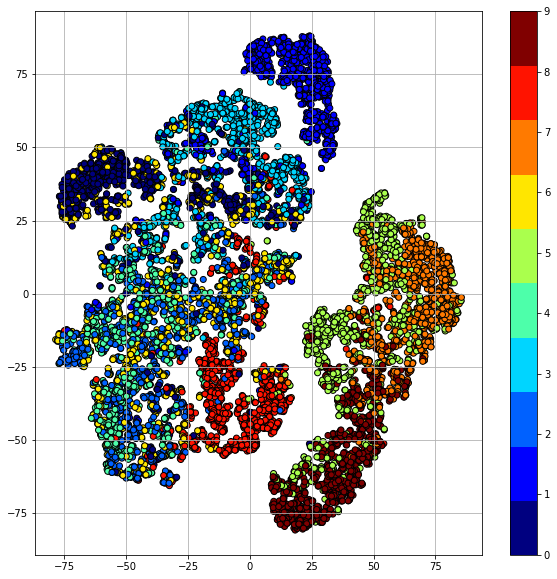

Finish!


In [9]:
with torch.no_grad():
    model = trainer.model
    model.eval()
    z=[];label=[]
    for x,y in trainer.val_loader:
        x = x.view(x.size(0),-1)
        z_ = model.encoder(x.to(trainer.device))
        z += z_.cpu().tolist()
        label += y.cpu().tolist()
    z = np.asarray(z)
    label = np.asarray(label)

from VAE_starter import scatter_plot
scatter_plot(latent_representations=z,labels=label)
print("Finish!")

## Generating Images by Sampling Bottleneck Features

So here we can generate new images by sampling bottleneck features, and use the decoder to generate images. 

The code below provides an example of how to generate images by sampling bottleneck features. 

The `display_images_in_a_row` takes the following arguments:
* images: (N,28,28): N images of 28*28 as a numpy array
* file_path: file path name for where to store the figure
* display: display the image or not


In [ ]:
with torch.no_grad():
    samples = torch.randn(7, rep_dim).to(trainer.device)
#     print(samples)
    samples = trainer.model.decoder(samples).cpu()

images = samples

from autoencoder_starter import display_images_in_a_row
display_images_in_a_row(images)

## Reconstructing Images

We can first retrieve the validation set and then pick 64 images (the first 64 images, though you can do it randomly).

We use the autoencoder to reconstruct the images and visualize them below.

In [ ]:
images = trainer.get_val_set() # get the entire validation set
total_number = 64
images = images[:total_number]

from autoencoder_starter import display_images_in_a_row
print("Original images")
display_images_in_a_row(images.cpu())

In [ ]:
#Vanilla, DAE Reconstruction
with torch.no_grad():
    images = images.to(trainer.device)
    images = images.view(images.size(0), -1)
    reconstructed = trainer.model(images)
    reconstructed = reconstructed.cpu()
print("Reconstructed images")
display_images_in_a_row(reconstructed)

In [ ]:
#VAE Reconstruction
with torch.no_grad():
    images = images.to(trainer.device)
    images = images.view(images.size(0), -1)
    reconstructed, mu, logvar = trainer.model(images)
    reconstructed = reconstructed.cpu()
print("Reconstructed images")
display_images_in_a_row(reconstructed)

In [ ]:

%reload_ext autoreload
from autoencoder_starter import Plot_Kernel
Plot_Kernel(model)

In [ ]:
# for layer_index, layer_weight in enumerate(y):
